In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

sys.path.append("..")

from model import TFModel
from main import Config

2.1.0+cu121


In [2]:
# one-layer
pt_one_layer = "1_layer_64_vocab/ckpt.pt"
cf_one_layer = "1_layer_64_vocab/config.json"

config = Config(**json.load(open(cf_one_layer, "r")))
model = TFModel(config)
model.load_state_dict(torch.load(pt_one_layer))
model.to(config.device)

TFModel(
  (embed): Embedding(
    (embed): Embedding(64, 64)
  )
  (h): ModuleList(
    (0): TFBlock(
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=True)
        (W_k): Linear(in_features=64, out_features=64, bias=True)
        (W_v): Linear(in_features=64, out_features=64, bias=True)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=64, out_features=64, bias=True)
)

We observe that the ID error decreases and OOD error stays high. Our hypothesis is that model learns the
distribution of tokens, which is based on power law. How to achieve this? The first component is a close-to-identity
attention pattern. The second component is on the MLP parameters.

In [3]:
test, test_lens, test_starts = torch.load("1_layer_64_vocab/test.pth")
from collections import Counter

Counter(torch.argmax(model(test), dim=-1)[5:, :].flatten().numpy(force=True))

Counter({0: 315671,
         5: 354,
         7: 280,
         6: 257,
         9: 232,
         14: 173,
         10: 156,
         19: 151,
         12: 146,
         48: 132,
         55: 125,
         17: 122,
         13: 114,
         15: 110,
         47: 109,
         18: 108,
         21: 100,
         24: 100,
         16: 96,
         63: 95,
         23: 94,
         58: 85,
         29: 81,
         32: 80,
         46: 80,
         28: 73,
         30: 73,
         27: 73,
         39: 72,
         50: 72,
         45: 71,
         51: 58,
         61: 50,
         44: 48,
         42: 39})

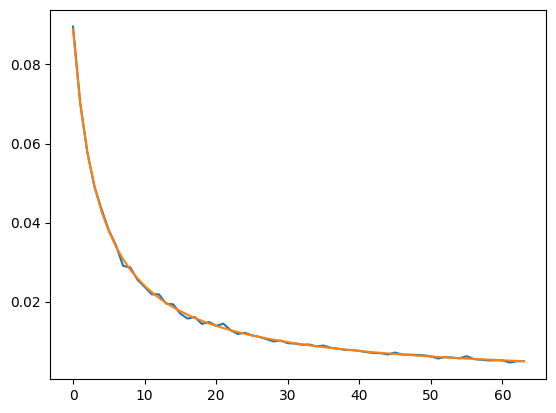

In [14]:
import torch.nn.functional as F

p1 = F.softmax(model(test), dim=-1).mean(0).mean(0).numpy(force=True)
p2 = np.array([1 / (i + 2.7) for i in range(1, config.vocab_size + 1)])
plt.plot(p1 / np.sum(p1))
plt.plot(p2 / np.sum(p2))